<a href="https://www.kaggle.com/code/tuananhphan1201/data-project-aqi?scriptVersionId=268889244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Air Quality Index (AQI) Data Analysis Project


Air pollution has become a major environmental concern, especially in large cities. The Air Quality Index (AQI) is a composite measure that reflects the overall level of air contamination and its potential impact on human health. 

This project focuses on exploring, visualizing, and modeling AQI data to uncover trends, identify relationships between pollutants, and build a predictive model capable of estimating air quality based on measurable environmental factors.

Throughout this notebook, several steps are performed:
- **Data Exploration (EDA):** examining the dataset structure, distributions, correlations, and temporal trends.
- **Data Cleaning:** handling missing values, outliers, and temporal interpolation.
- **Modeling:** training machine learning models (such as XGBoost) to predict AQI levels.
- **Evaluation and Interpretation:** assessing model performance and interpreting feature importance.

The analysis provides both statistical insights and practical interpretations of how pollutant levels contribute to air quality fluctuations.


# First look at the data

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        df = pd.read_csv(os.path.join(dirname, filename), sep=',')

print(f">>> Input data found:")
print(df.describe(), "\n")
print(df.info(), "\n")

>>> Input data found:
                lon           lat           aqi            co            no  \
count  2.568000e+04  2.568000e+04  25680.000000  25680.000000  25680.000000   
mean   1.066953e+02  1.078280e+01      3.108217   1401.490751     20.717377   
std    3.565573e-11  6.830225e-12      1.384412   1462.820043     36.133540   
min    1.066953e+02  1.078280e+01      0.000000     93.930000      0.000000   
25%    1.066953e+02  1.078280e+01      2.000000    567.440000      0.460000   
50%    1.066953e+02  1.078280e+01      3.000000    879.215000      3.970000   
75%    1.066953e+02  1.078280e+01      5.000000   1668.930000     25.930000   
max    1.066953e+02  1.078280e+01      5.000000  13885.500000    368.360000   

                no2            o3           so2         pm2_5          pm10  \
count  25680.000000  25680.000000  25680.000000  25680.000000  25680.000000   
mean      33.993987     27.013123     37.936970     59.832324     72.486850   
std       92.046817     75.09

# Exploratory Data Analysis (EDA)

The EDA phase aims to gain an initial understanding of the dataset before modeling.  
Key goals include:
- Detecting missing or abnormal values in pollutant measurements.  
- Understanding the statistical distribution of AQI and pollutants.  
- Exploring correlations between variables.  
- Identifying temporal trends (daily, monthly, and seasonal patterns).  

Visual and numerical exploration helps determine whether certain pollutants or weather indicators strongly influence AQI, and whether time-dependent variations exist.

In [2]:
columns_to_drop = ['lon','lat']

df_fix = df.drop(columns=columns_to_drop, axis=1)

df_fix['dt'] = pd.to_datetime(df_fix['dt'])
df_fix.set_index('dt', inplace=True)
df_fix.sort_index(inplace=True)

df_fix.replace([np.inf, 0.0, -9999.0, 9999.0, -np.inf], np.nan, inplace=True)
df_fix.interpolate(method='time', limit_direction='both', inplace=True)

print(df_fix.info(), "\n")
print(df_fix.describe(), "\n")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25680 entries, 2022-10-12 20:00:00 to 2025-10-11 19:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aqi     25680 non-null  float64
 1   co      25680 non-null  float64
 2   no      25680 non-null  float64
 3   no2     25680 non-null  float64
 4   o3      25680 non-null  float64
 5   so2     25680 non-null  float64
 6   pm2_5   25680 non-null  float64
 7   pm10    25680 non-null  float64
 8   nh3     25680 non-null  float64
dtypes: float64(9)
memory usage: 2.0 MB
None 

                aqi            co            no           no2            o3  \
count  25680.000000  25680.000000  25680.000000  25680.000000  25680.000000   
mean       3.108294   1401.490751     20.725087     34.774394     27.453520   
std        1.384293   1462.820043     36.129347     25.141123     41.503261   
min        1.000000     93.930000      0.010000      0.580000      0.010000   
25%     

Plot to see distribution

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x700 with 0 Axes>

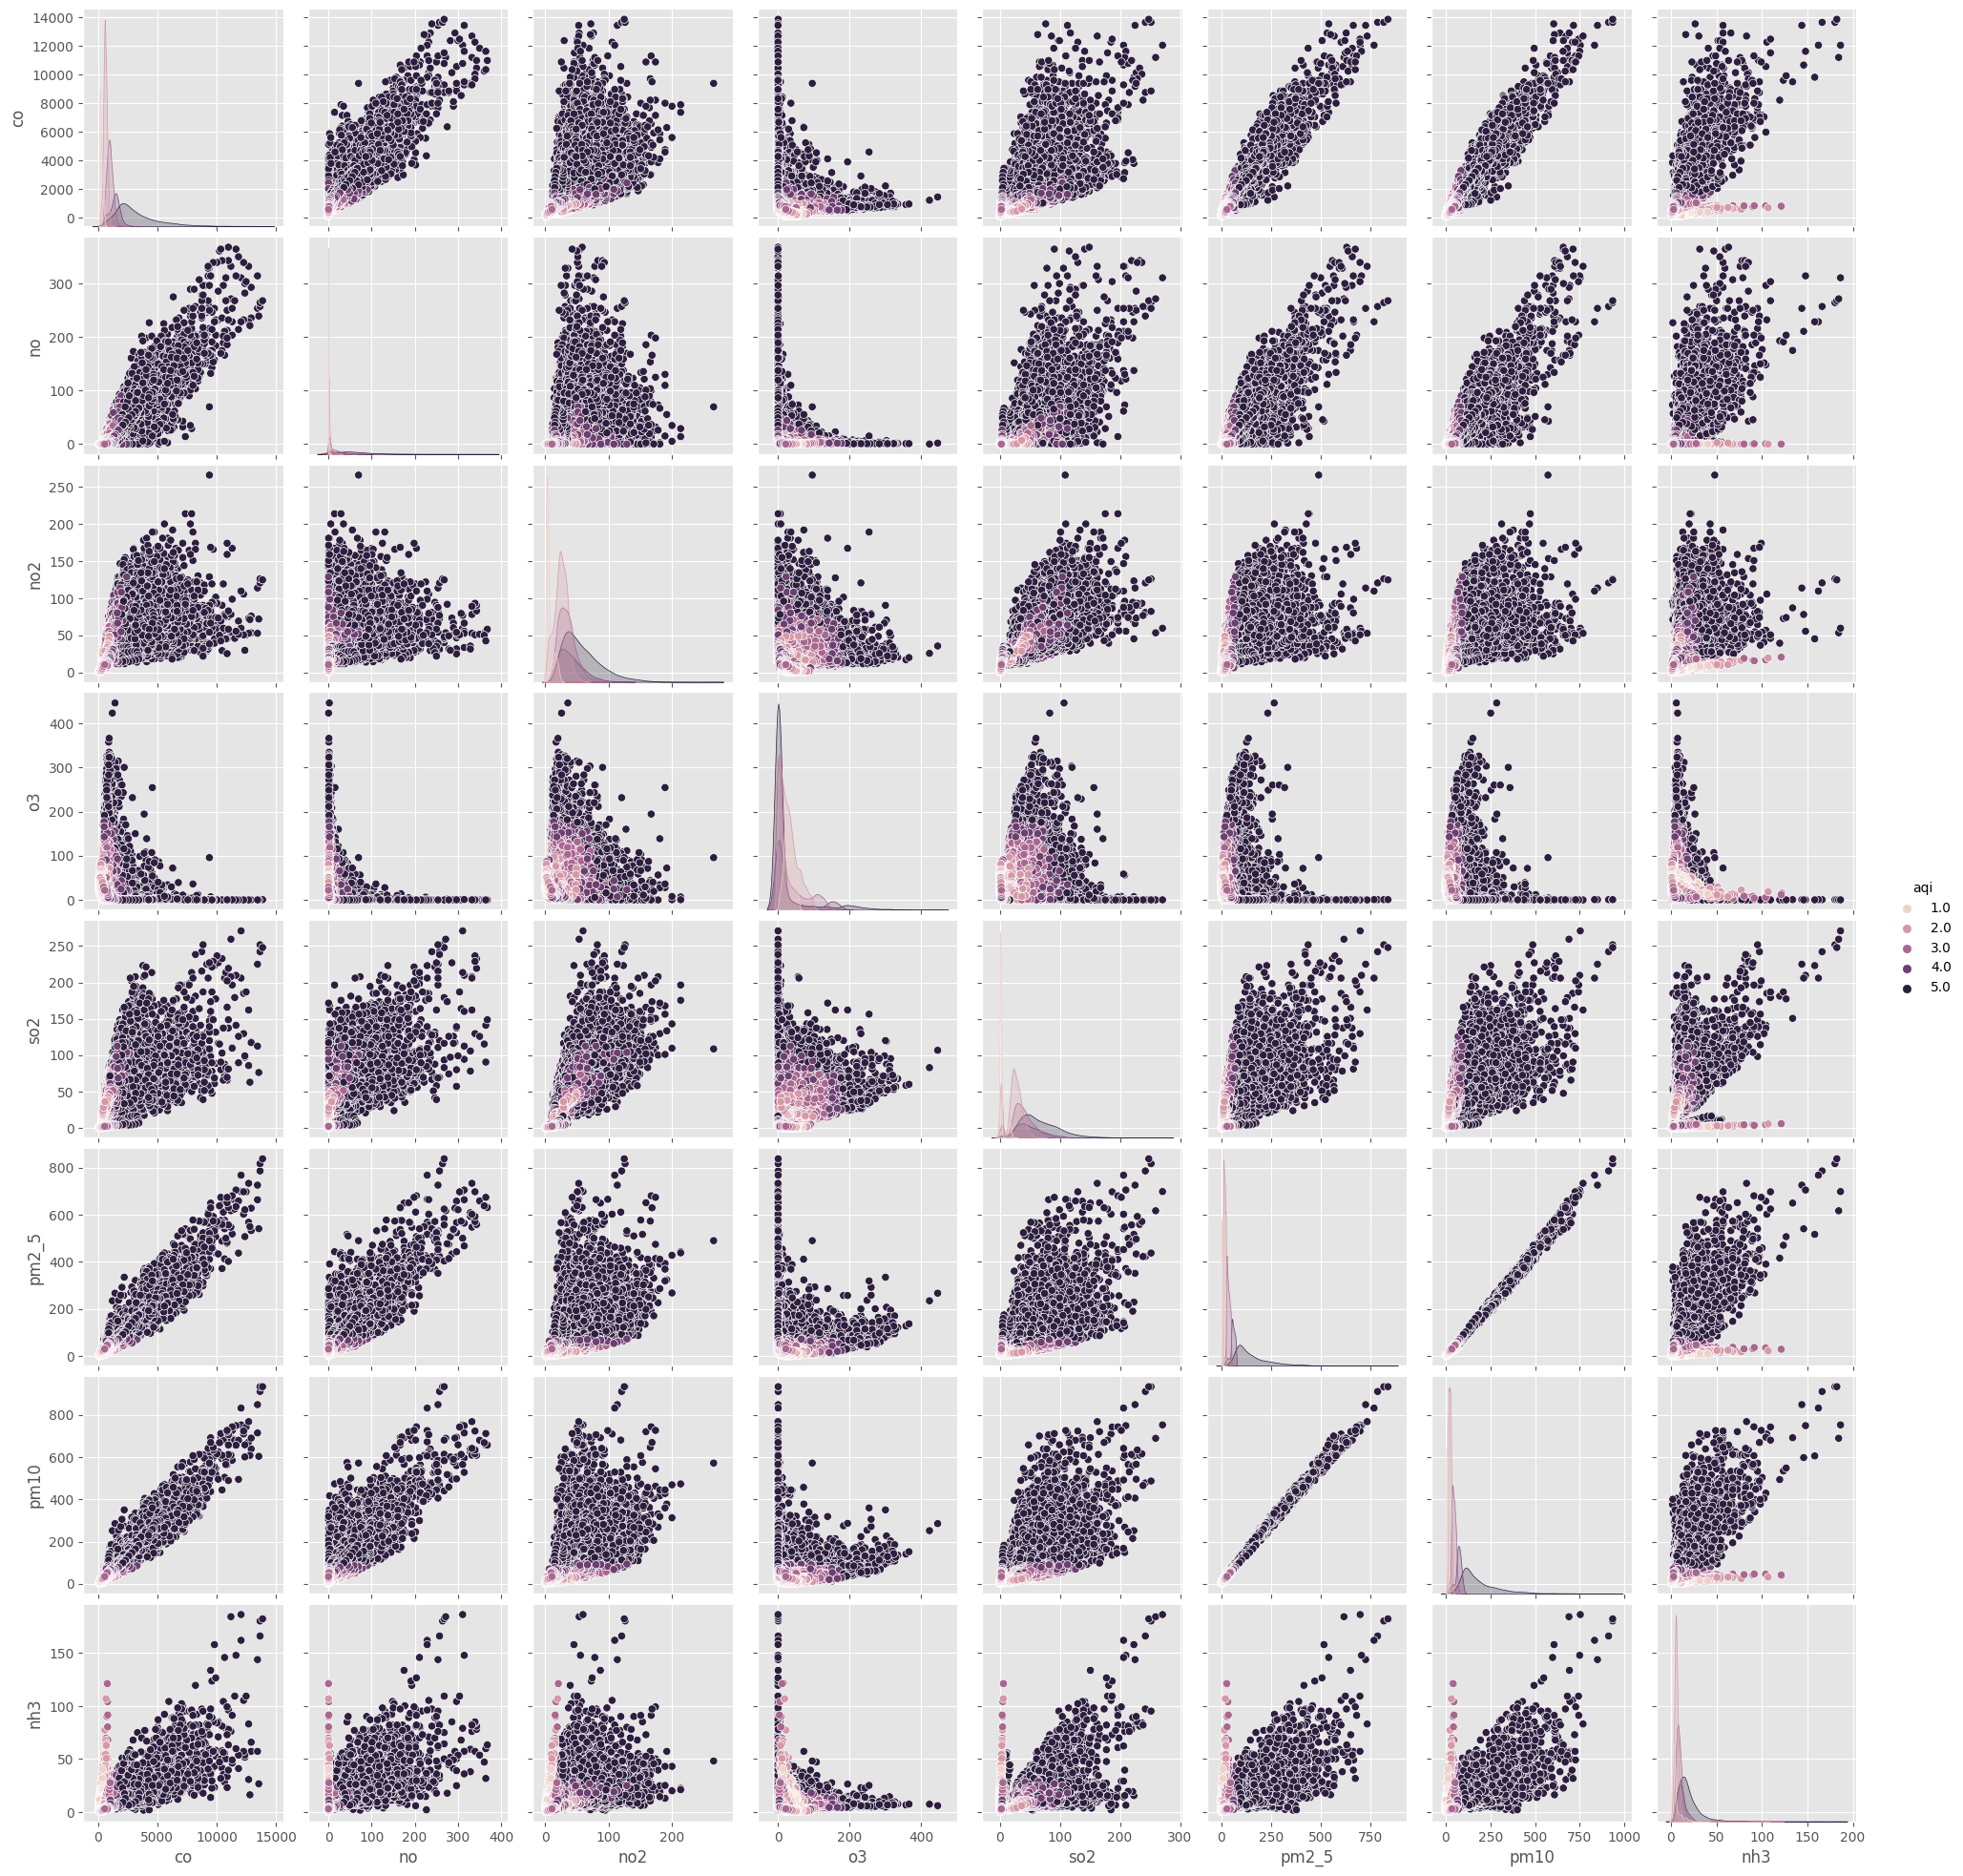

In [3]:
import matplotlib.pylab as plt
plt.style.use('ggplot')
import seaborn as sns

def plotWithAQI(df):
    plt.figure(figsize=(15, 7))
    sns.pairplot(df, hue='aqi')    
    plt.show()

plotWithAQI(df_fix)

COMMENT:

* some invalid
* some outliers

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x700 with 0 Axes>

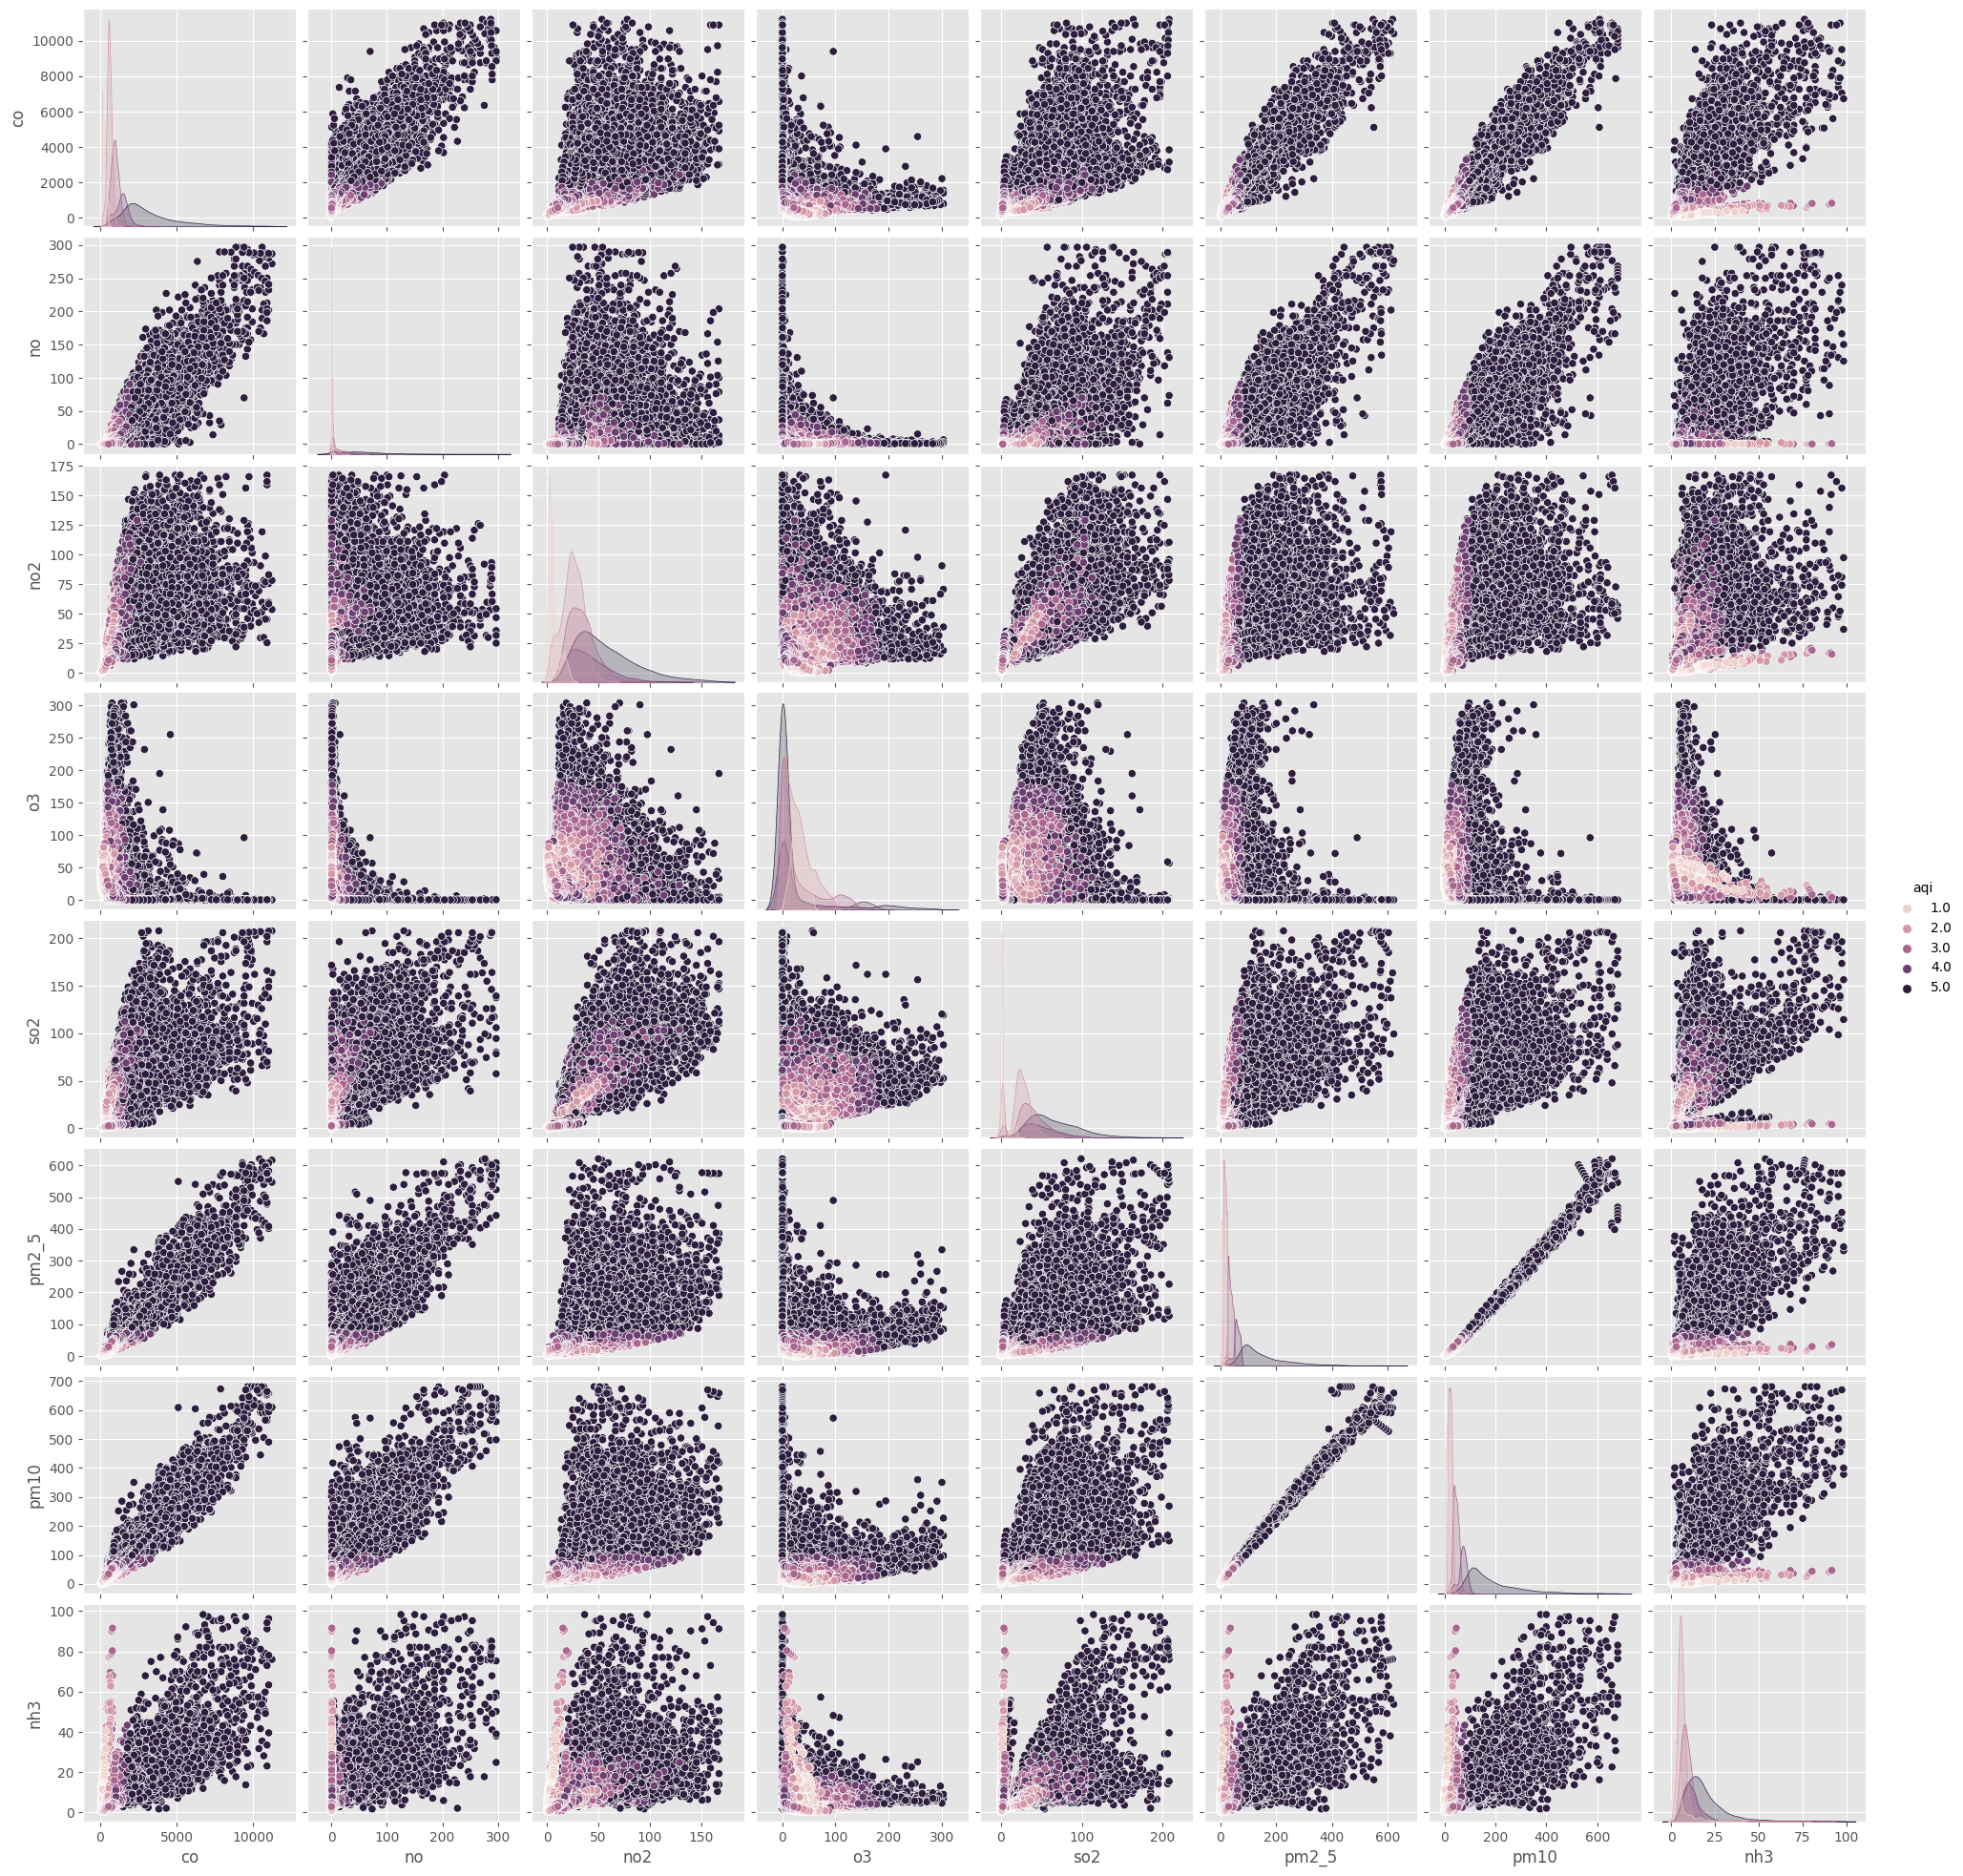

In [4]:
mjr_params = ['co', 'no2', 'pm2_5', 'pm10', 'o3', 'so2']
mnr_params = ['nh3', 'no']
params = mjr_params + mnr_params

def simulate_outliers_iqr(df, column_name):

    upper_bound = df[column_name].quantile(0.999)
    
    capped_column = np.where(
        df[column_name] > upper_bound, 
        0,
        df[column_name]
    )

    return capped_column

df_capped = df_fix.copy()
for param in params:
    df_capped[param] = simulate_outliers_iqr(df_capped, param)

df_capped.replace([0.0, 0], np.nan, inplace=True)
df_capped.interpolate(method='time', limit_direction='both', inplace=True)

plotWithAQI(df_capped)

COMMENT

# Time-series specifics
desc

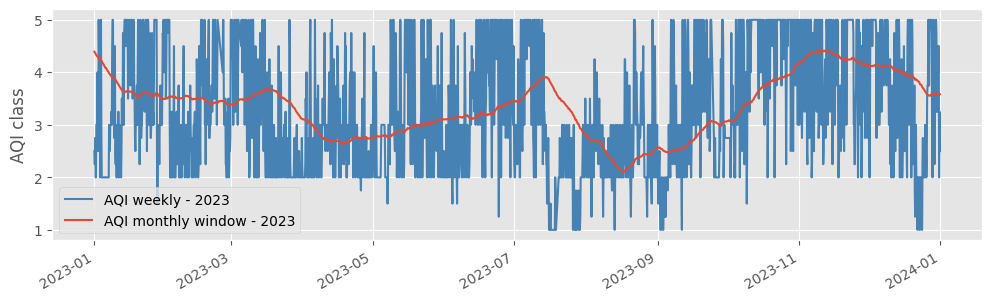

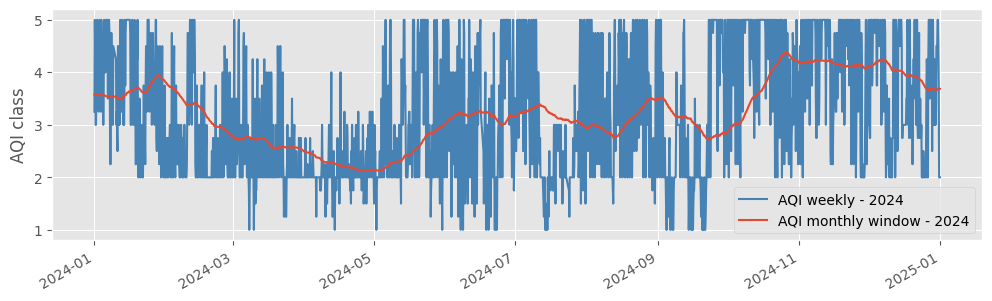

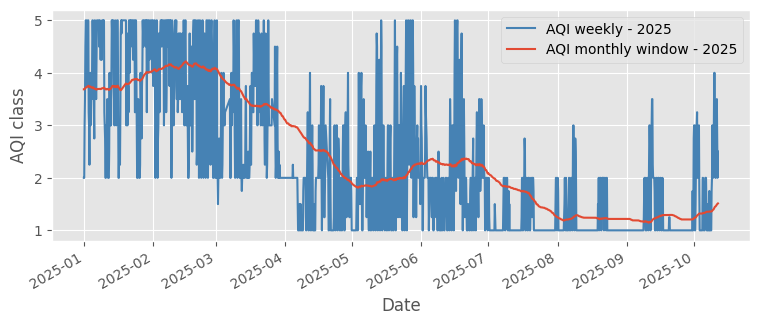

In [5]:
df_daily = df_capped['aqi'].resample('4H').mean()
df_daily = df_daily.interpolate(method='time', limit_direction='both')
df_daily_ma = df_daily.rolling(window=200).mean()

years = [2023,2024]

for year in years:
    df_year = df_daily[df_daily.index.year == year]
    df_year_ma = df_daily_ma[df_daily_ma.index.year == year]

    fig, ax = plt.subplots(figsize=(12, 3))
    
    ax.plot(df_year.index, df_year.values, label=f'AQI weekly - {year}', color='steelblue')
    ax.plot(df_year_ma.index, df_year_ma.values, label=f'AQI monthly window - {year}')
    
    ax.set_ylabel('AQI class', fontsize=12)
    ax.legend()    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha="right")
    
    plt.show()

year = 2025
df_year = df_daily[df_daily.index.year == year]
df_year_ma = df_daily_ma[df_daily_ma.index.year == year]

fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(df_year.index, df_year.values, label=f'AQI weekly - {year}', color='steelblue')
ax.plot(df_year_ma.index, df_year_ma.values, label=f'AQI monthly window - {year}')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('AQI class', fontsize=12)
ax.legend()    
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha="right")

plt.show()

In [6]:
df_capped['hour'] = df_capped.index.hour
df_capped['dayofweek'] = df_capped.index.dayofweek
df_capped['month'] = df_capped.index.month

df_capped['hour_sin'] = np.sin(2 * np.pi * df_capped['hour'] / 24)
df_capped['hour_cos'] = np.cos(2 * np.pi * df_capped['hour'] / 24)
df_capped['dayofweek_sin'] = np.sin(2 * np.pi * df_capped['dayofweek'] / 7)
df_capped['dayofweek_cos'] = np.cos(2 * np.pi * df_capped['dayofweek'] / 7)

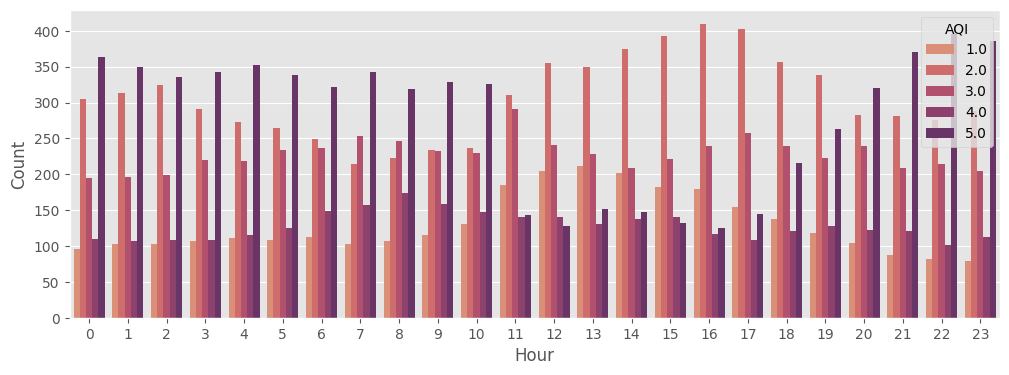

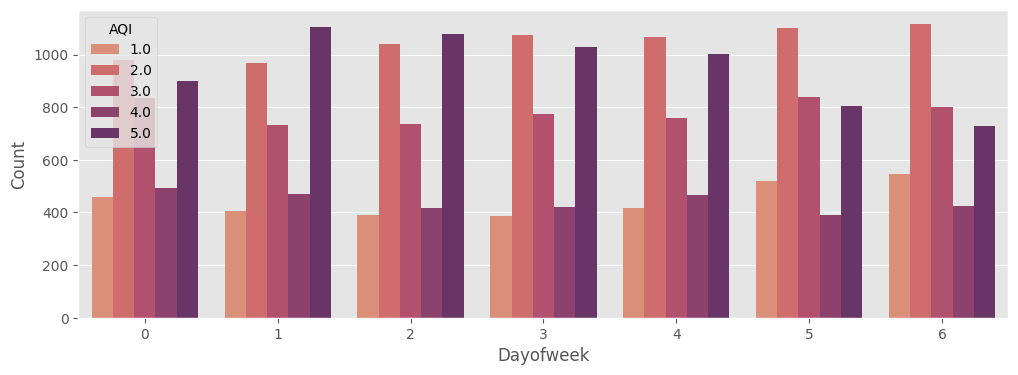

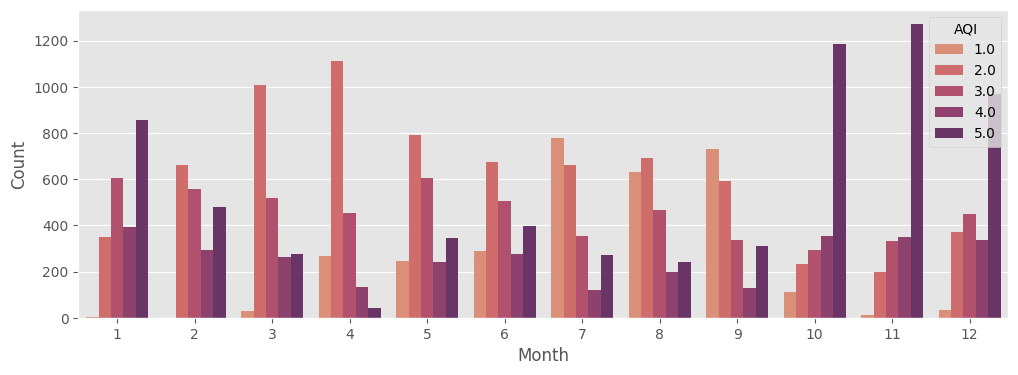

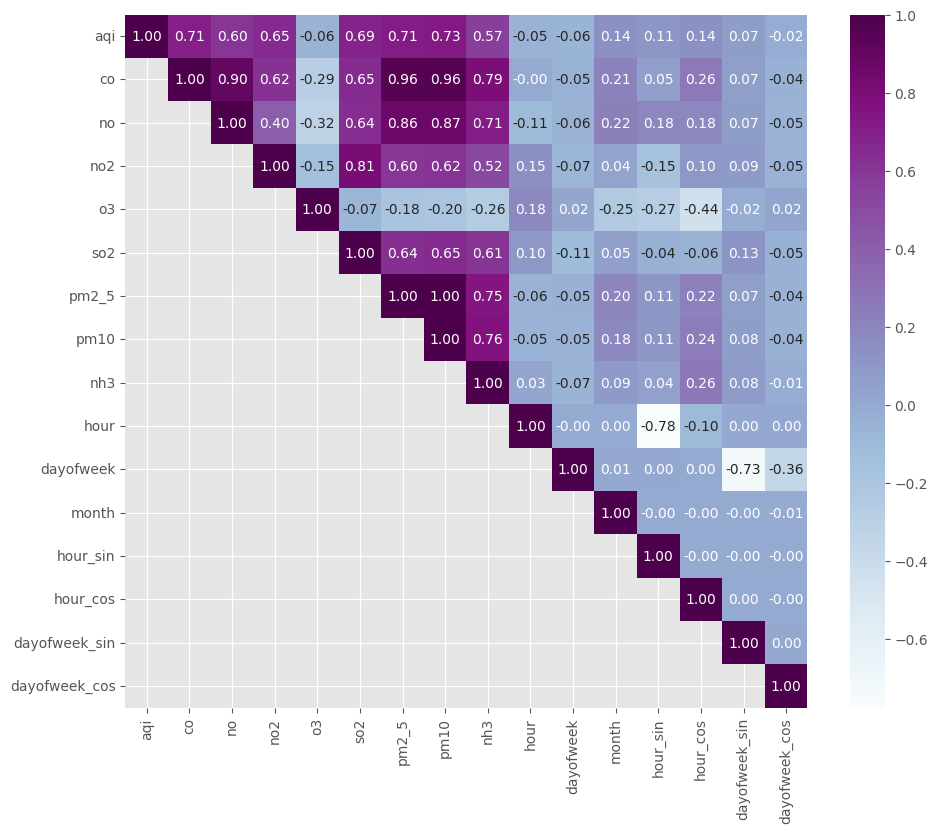

In [7]:
time_features = ['hour', 'dayofweek', 'month']

for feature in time_features:
    plt.figure(figsize=(12, 4))
    
    sns.countplot(
        data=df_capped, 
        x=feature,  # Tiêu chí thời gian làm trục X
        hue='aqi', # Các lớp AQI sẽ được đếm và tô màu
        palette="flare" 
    )
    
    plt.xlabel(feature.capitalize(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='AQI')
    plt.show()

corr_matrix = df_capped.corr()
triangle_mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)

plt.figure(figsize=(11, 9))
sns.heatmap(
    corr_matrix, 
    mask=triangle_mask,
    annot=True,
    fmt=".2f",
    cmap='BuPu'
)
plt.show()

From the visualizations and statistical exploration:

- **Distribution:** The AQI distribution is slightly right-skewed, indicating that most days have moderate air quality but a few outliers correspond to heavy pollution episodes.  
- **Correlation:** Several pollutants (such as PM2.5 and PM10) show strong positive correlation with AQI, while some gaseous pollutants (like O₃) may behave inversely depending on meteorological conditions.  
- **Temporal Trends:**  
  - The monthly AQI plot reveals potential **seasonal variation**, where pollution tends to peak in specific months (often during dry or cooler seasons).  
  - The hourly pattern suggests **daily cycles**, possibly linked to traffic or industrial activity peaking in the morning and evening hours.  

These findings highlight the importance of incorporating temporal and multi-feature interactions when building predictive models.


# Feature Engineering
desc

In [8]:
def create_advanced_features(df, pollutants):
    features_list = []
    
    lags = [1, 2, 4, 8, 12, 24]
    windows = [3, 6, 9, 12, 24]

    for col in pollutants:
        for lag in lags:
            lag_series = df[col].shift(lag)
            lag_series.name = f'{col}_lag_{lag}h'
            features_list.append(lag_series)
        
        for window in windows:
            roll_mean_series = df[col].rolling(window=window).mean()
            roll_mean_series.name = f'{col}_roll_mean_{window}h'
            features_list.append(roll_mean_series)
            
            roll_std_series = df[col].rolling(window=window).std()
            roll_std_series.name = f'{col}_roll_std_{window}h'
            features_list.append(roll_std_series)
            
    if 'pm2.5' in pollutants and 'pm10' in pollutants:
        ratio_series = df['pm2.5'] / df['pm10']
        ratio_series.name = 'pm2.5_to_pm10_ratio'
        features_list.append(ratio_series)
        
    df_feat = pd.concat([df] + features_list, axis=1)
        
    return df_feat

df_featured = create_advanced_features(df_capped, params)
df_featured = df_featured.dropna()

# Model training

After completing exploratory data analysis and data preprocessing, this section focuses on building machine learning models to predict the Air Quality Index (AQI) category or value.

The modeling workflow includes:
1. **Feature Preparation:** Selecting relevant pollutant and meteorological features.  
2. **Data Splitting:** Dividing the dataset into training and testing subsets.  
3. **Model Training:** Using XGBoost as the main predictive model, with Logistic Regression as a baseline.  
4. **Evaluation:** Assessing accuracy, F1-score, and confusion matrix to understand model performance.  
5. **Interpretation:** Analyzing feature importance to identify which variables most strongly influence AQI.

In [9]:
aqi_labels_map = {
    0: 'Tốt',
    1: 'Trung bình',
    2: 'Kém',
    3: 'Xấu',
    4: 'Rất xấu' 
}
label_names = [aqi_labels_map[i] for i in range(len(aqi_labels_map))]

df_featured['aqi'] = df_featured['aqi'].shift(-1)
df_featured.dropna(inplace=True)

y_numeric = df_featured['aqi'] - df_featured['aqi'].min()
y_label = y_numeric.map(aqi_labels_map)

X = df_featured.drop(columns=['aqi'])

split_point = int(len(df_featured) * 0.70)

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y_numeric[:split_point], y_numeric[split_point:]
y_train_label, y_test_label = y_label[:split_point], y_label[split_point:]

print(f"Kích thước tập huấn luyện: {X_train.shape},  {y_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape},  {y_test.shape}")

Kích thước tập huấn luyện: (17958, 143),  (17958,)
Kích thước tập kiểm tra: (7697, 143),  (7697,)


In [10]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
model = xgb.XGBClassifier(
    objective='multi:softmax',
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train,
          y_train,
          sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

# Model brief evaluation
desc

Accuracy: 0.87085878

Classification report:
               precision    recall  f1-score   support

         Tốt       0.92      0.97      0.95      2548
  Trung bình       0.91      0.83      0.87      1917
         Kém       0.80      0.77      0.78      1206
         Xấu       0.64      0.66      0.65       695
     Rất xấu       0.89      0.94      0.91      1331

    accuracy                           0.87      7697
   macro avg       0.83      0.83      0.83      7697
weighted avg       0.87      0.87      0.87      7697



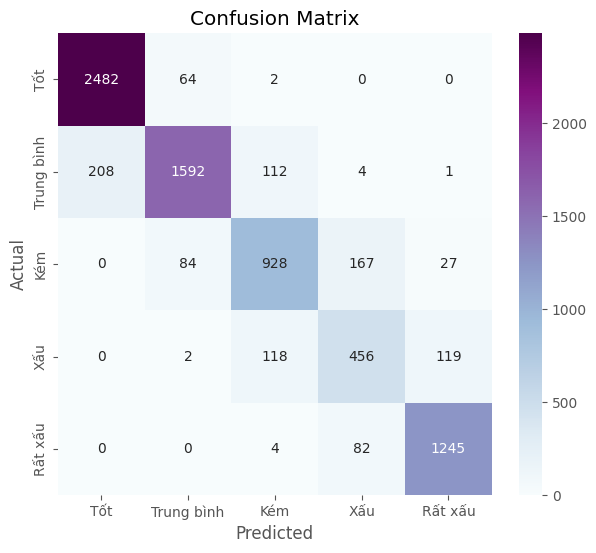

In [11]:
y_predictions_numeric = model.predict(X_test)
y_predictions_label = pd.Series(y_predictions_numeric).map(aqi_labels_map)

accuracy = accuracy_score(y_test, y_predictions_numeric)
print(f"Accuracy: {accuracy:.8f}")

report = classification_report(
    #y_test_label,
    y_test,
    #y_predictions_label,
    y_predictions_numeric,
    target_names=label_names)

print("\nClassification report:\n", report)


#cm = confusion_matrix(y_test_label, y_predictions_label)
cm = confusion_matrix(y_test, y_predictions_numeric)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='BuPu',
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

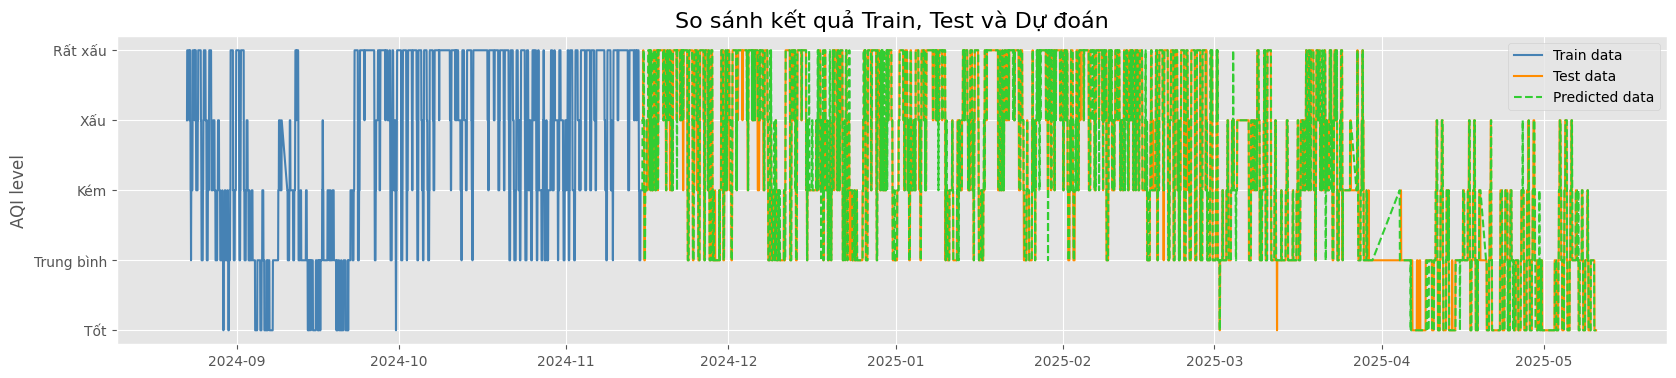

In [12]:
predictions_series = pd.Series(y_predictions_numeric, index=y_test.index)
predictions_series.name = 'Predicted'

plt.figure(figsize=(20, 4))

y_train_shortened = y_train.tail(2000)
plt.plot(y_train_shortened.index, y_train_shortened, label='Train data', color='steelblue')

y_test_shortened = y_test.head(4000)
plt.plot(y_test_shortened.index, y_test_shortened, label='Test data', color='darkorange')

predictions_series_shortened = predictions_series.head(4000)
plt.plot(predictions_series_shortened.index, predictions_series_shortened, label='Predicted data', color='limegreen', linestyle='--')

plt.title('So sánh kết quả Train, Test và Dự đoán', fontsize=16)
plt.ylabel('AQI level', fontsize=12)
plt.yticks(ticks=np.arange(len(label_names)), labels=label_names)
plt.legend()
plt.grid(True)
plt.show()

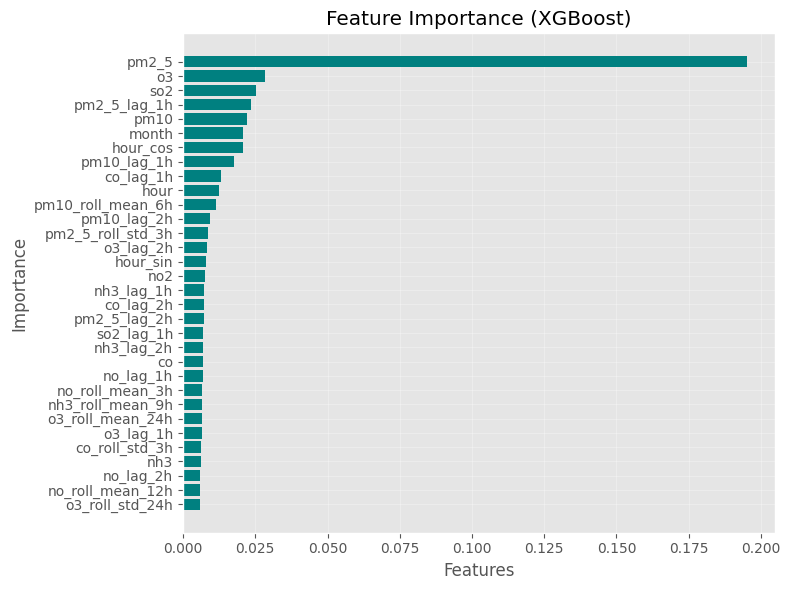

In [13]:
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

features = np.array(X.columns)
top_n = 32
top_features = features[sorted_idx][:top_n]
top_importance = importance[sorted_idx][:top_n]

# Vẽ barplot
plt.figure(figsize=(8,6))
plt.barh(top_features[::-1], top_importance[::-1], color='teal')
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
import joblib

joblib.dump(model, "aqi_model.pkl")
feature_list = list(X.columns)
joblib.dump(feature_list, "features.pkl")
print('Model with ', len(feature_list), 'features exported:\n')
print(feature_list)

print(f"Model feature exported")

Model with  143 features exported:

['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'co_lag_1h', 'co_lag_2h', 'co_lag_4h', 'co_lag_8h', 'co_lag_12h', 'co_lag_24h', 'co_roll_mean_3h', 'co_roll_std_3h', 'co_roll_mean_6h', 'co_roll_std_6h', 'co_roll_mean_9h', 'co_roll_std_9h', 'co_roll_mean_12h', 'co_roll_std_12h', 'co_roll_mean_24h', 'co_roll_std_24h', 'no2_lag_1h', 'no2_lag_2h', 'no2_lag_4h', 'no2_lag_8h', 'no2_lag_12h', 'no2_lag_24h', 'no2_roll_mean_3h', 'no2_roll_std_3h', 'no2_roll_mean_6h', 'no2_roll_std_6h', 'no2_roll_mean_9h', 'no2_roll_std_9h', 'no2_roll_mean_12h', 'no2_roll_std_12h', 'no2_roll_mean_24h', 'no2_roll_std_24h', 'pm2_5_lag_1h', 'pm2_5_lag_2h', 'pm2_5_lag_4h', 'pm2_5_lag_8h', 'pm2_5_lag_12h', 'pm2_5_lag_24h', 'pm2_5_roll_mean_3h', 'pm2_5_roll_std_3h', 'pm2_5_roll_mean_6h', 'pm2_5_roll_std_6h', 'pm2_5_roll_mean_9h', 'pm2_5_roll_std_9h', 'pm2_5_roll_mean_12h', 'pm2_5_roll_std